In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt
import logging
from transformers import BitsAndBytesConfig
from torch import cuda, bfloat16


cuda.empty_cache()
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
# model_name = "Qwen/Qwen2.5-0.5B-Instruct"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
# model_name = "microsoft/Phi-3.5-mini-instruct"
# model_name = "meta-llama/Llama-2-7b-hf"

quantization_config = BitsAndBytesConfig(load_in_8bit=True)
device_map={"": 0}

# model = AutoModelForCausalLM.from_pretrained(model_name, attn_implementation="eager")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device_map,
    quantization_config=quantization_config, 
    attn_implementation="eager",
)

model.config.use_cache = False
model.config.pretraining_tp = 1

special_token_ids = []
for attr in [
            "bos_token_id",
            "eos_token_id",
            "pad_token_id",
            "unk_token_id",
            "sep_token_id",
            "mask_token_id",
            ]:
            token_id = getattr(tokenizer, attr, None)
            print(f"token: {attr} { token_id}")    
            
            if token_id is not None:
                special_token_ids.append(token_id)
            else:
                 print(f"token unknown: {token_id}")    

print(special_token_ids)
        

token: bos_token_id 128000
token: eos_token_id 128009
token: pad_token_id None
token unknown: None
token: unk_token_id None
token unknown: None
token: sep_token_id None
token unknown: None
token: mask_token_id None
token unknown: None
[128000, 128009]


In [3]:
max_new_tokens:int = 512
top_p:float = 0.90
top_k:int = 27
min_p:float = 0.03
generator: torch.Generator = torch.Generator(device=device).manual_seed(1337),
# Plot probabilities for each generated token at various temperatures
temperatures = torch.linspace(0.1, 2.0, 30)
top_n:int = 5  # Choose the top-N tokens to plot

In [ ]:
# model.to(device)

messages = [
    {
        "role": "user",
        "content": "'What is the name of the chemist who fully developed the aquarium principle in 1850, explaining that plants added to water in a container would give off enough oxygen to support animals, as long as the number of animals did not grow too large?'",
    }
]

if hasattr(tokenizer, "chat_template") and tokenizer.chat_template:
    input_text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
else:
    input_text = "\n".join([f"{msg['role']}: {msg['content']}" for msg in messages])
    input_text += "\nassistant:"

input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
attention_mask = torch.ones_like(input_ids).to(device)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

generated_tokens = []
gen_tokens = input_ids
past_key_values = None
stop = torch.tensor([tokenizer.eos_token_id], device=device, dtype=torch.int32)
start = torch.tensor([tokenizer.bos_token_id], device=device, dtype=torch.int32)

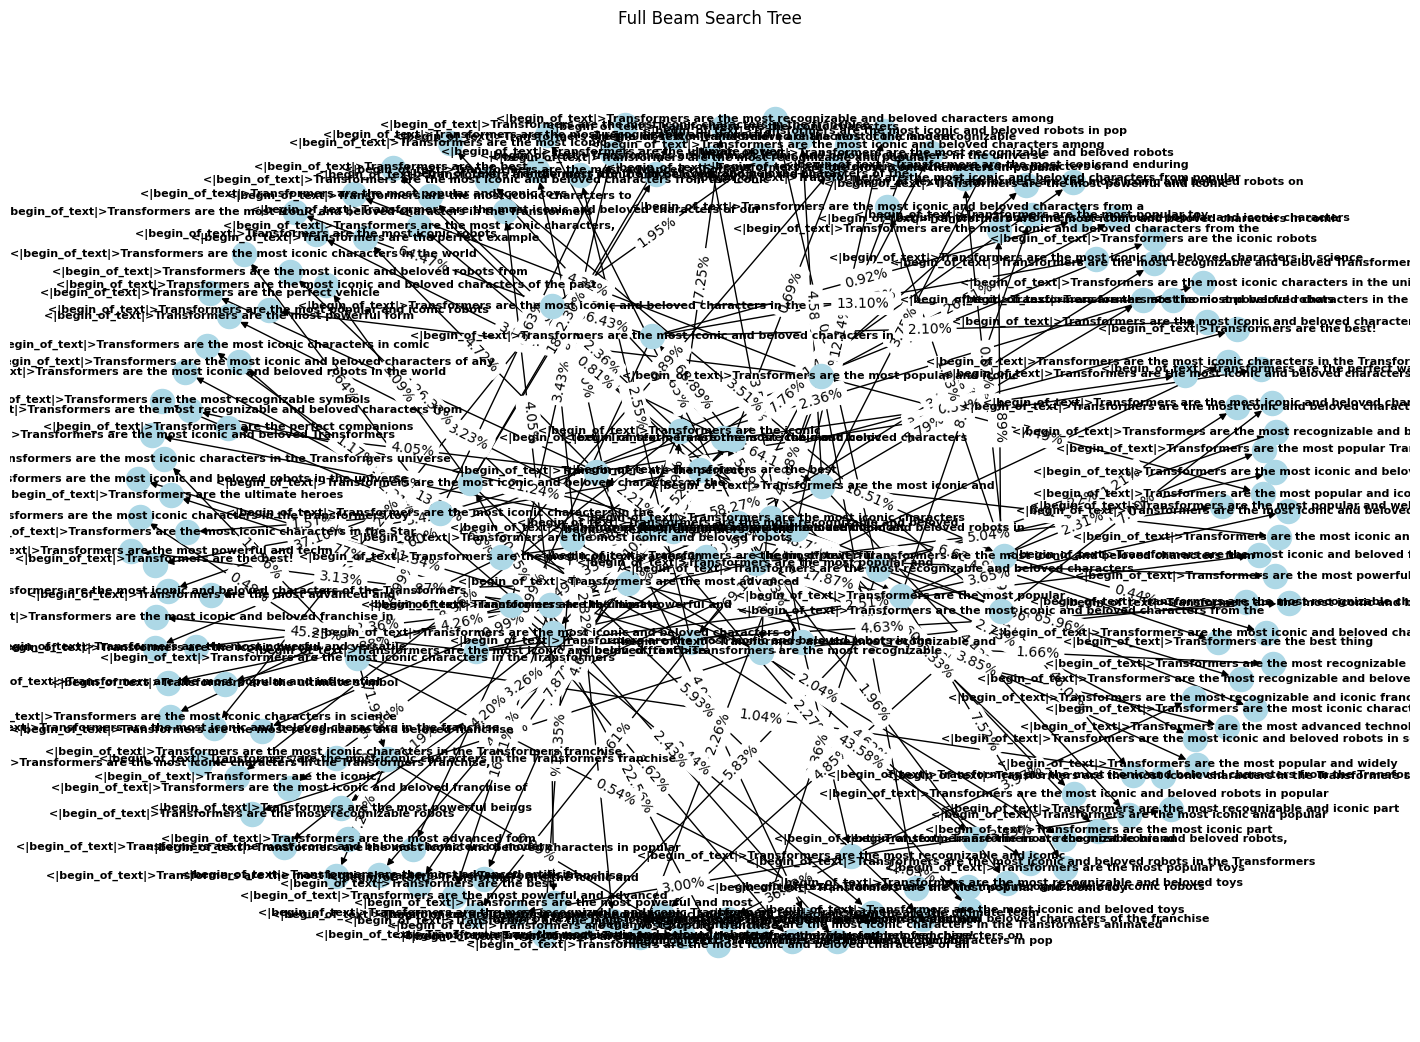

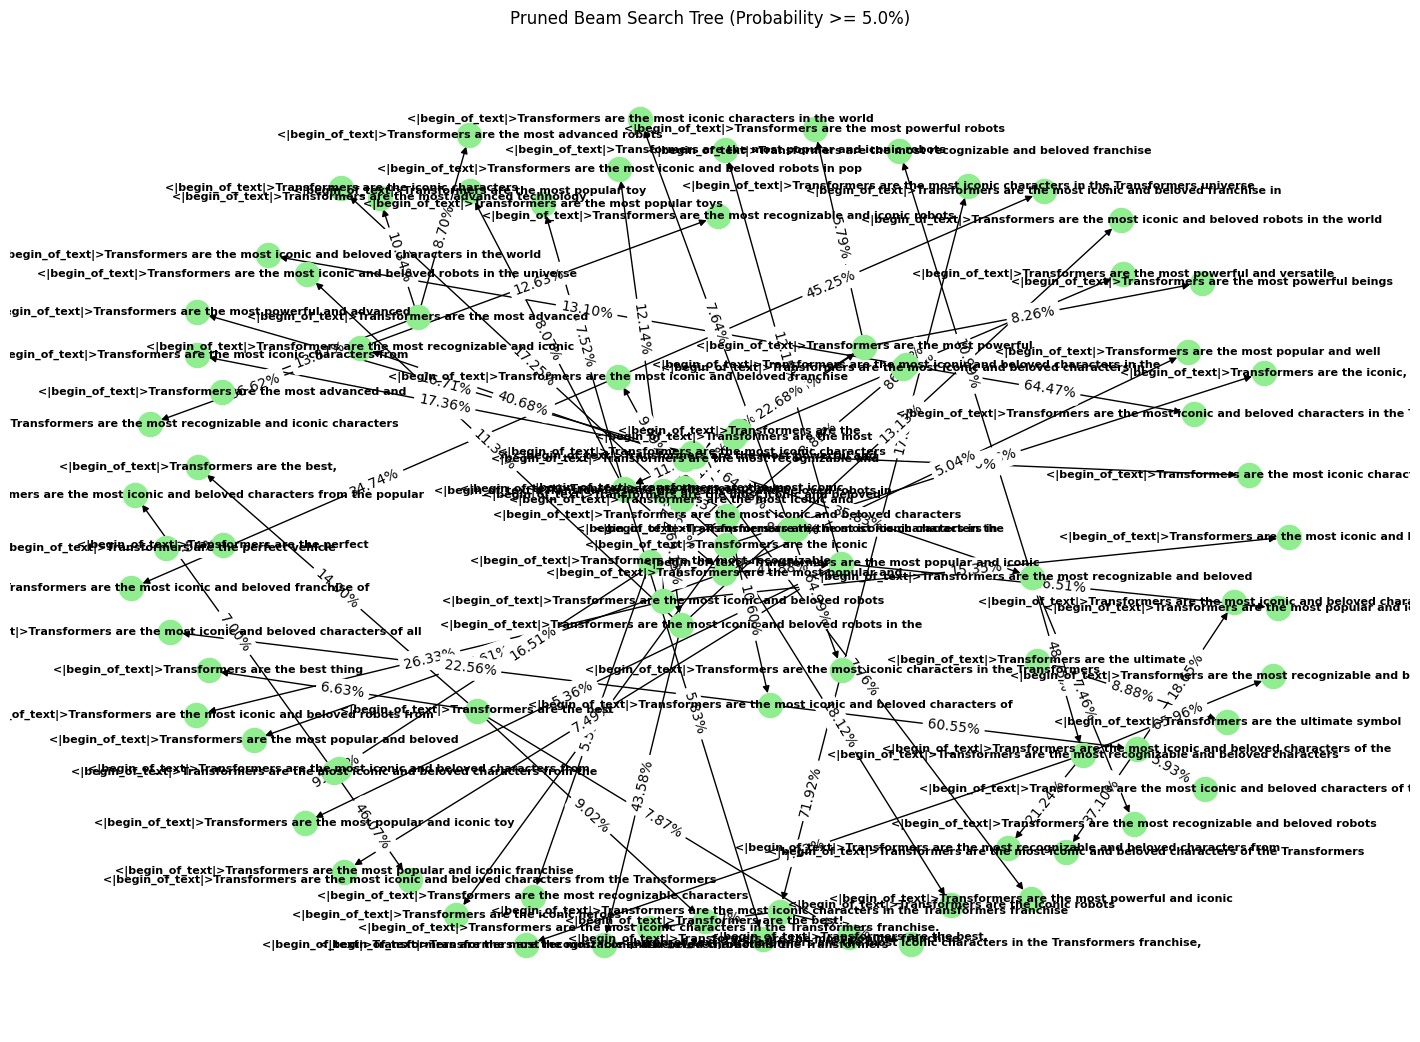

In [ ]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the model and tokenizer (replace with your model name)
# model_name = "gpt2"  # example, change to your model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)

# Beam search parameters
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(model.device)
n_steps = 8
beam_size = 5

# Initialize the beam
beams = [(input_ids, 1.0)]  # each beam is a tuple (input_ids, probability)
tree_structure = {}  # Dictionary to store tree structure for visualization

# Perform beam search
with torch.no_grad():
    for step in range(n_steps):
        new_beams = []
        for input_ids, prob in beams:
            # Generate logits for the current input
            output = model(input_ids=input_ids)
            next_token_logits = output.logits[0, -1, :]
            next_token_probs = torch.softmax(next_token_logits, dim=-1)

            # Get the top beam_size next tokens
            sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)[
                :beam_size
            ]
            for idx, token_id in enumerate(sorted_ids):
                if torch.isin(token_id, start).any():
                    continue
                token_prob = next_token_probs[token_id].item()
                new_prob = prob * token_prob  # Update probability
                new_input_ids = torch.cat([input_ids, token_id.view(1, 1)], dim=-1)

                # Update tree structure
                parent_text = tokenizer.decode(input_ids[0])
                child_text = tokenizer.decode(new_input_ids[0])
                tree_structure[(parent_text, child_text)] = (
                    100 * token_prob
                )  # Save as percentage

                # Store new beam
                new_beams.append((new_input_ids, new_prob))

        # Keep only the top beams after each step
        new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
        beams = new_beams  # Update beams


prob_threshold = 5.0

# Step 2: Prune the tree by creating a new tree with only edges above the probability threshold
pruned_tree_structure = {
    edge: prob for edge, prob in tree_structure.items() if prob >= prob_threshold
}

# Step 3: Visualize the Full Tree
G_full = nx.DiGraph()
for (parent, child), prob in tree_structure.items():
    G_full.add_edge(parent, child, weight=prob)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_full, seed=42)
edge_labels = nx.get_edge_attributes(G_full, "weight")
nx.draw(
    G_full,
    pos,
    with_labels=True,
    node_color="lightblue",
    font_size=8,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(
    G_full,
    pos,
    edge_labels={(u, v): f"{d:.2f}%" for u, v, d in G_full.edges(data="weight")},
)
plt.title("Full Beam Search Tree")
plt.show()

# Step 4: Visualize the Pruned Tree
G_pruned = nx.DiGraph()
for (parent, child), prob in pruned_tree_structure.items():
    G_pruned.add_edge(parent, child, weight=prob)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_pruned, seed=42)
edge_labels = nx.get_edge_attributes(G_pruned, "weight")
nx.draw(
    G_pruned,
    pos,
    with_labels=True,
    node_color="lightgreen",
    font_size=8,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(
    G_pruned,
    pos,
    edge_labels={(u, v): f"{d:.2f}%" for u, v, d in G_pruned.edges(data="weight")},
)
plt.title(f"Pruned Beam Search Tree (Probability >= {prob_threshold}%)")
plt.show()

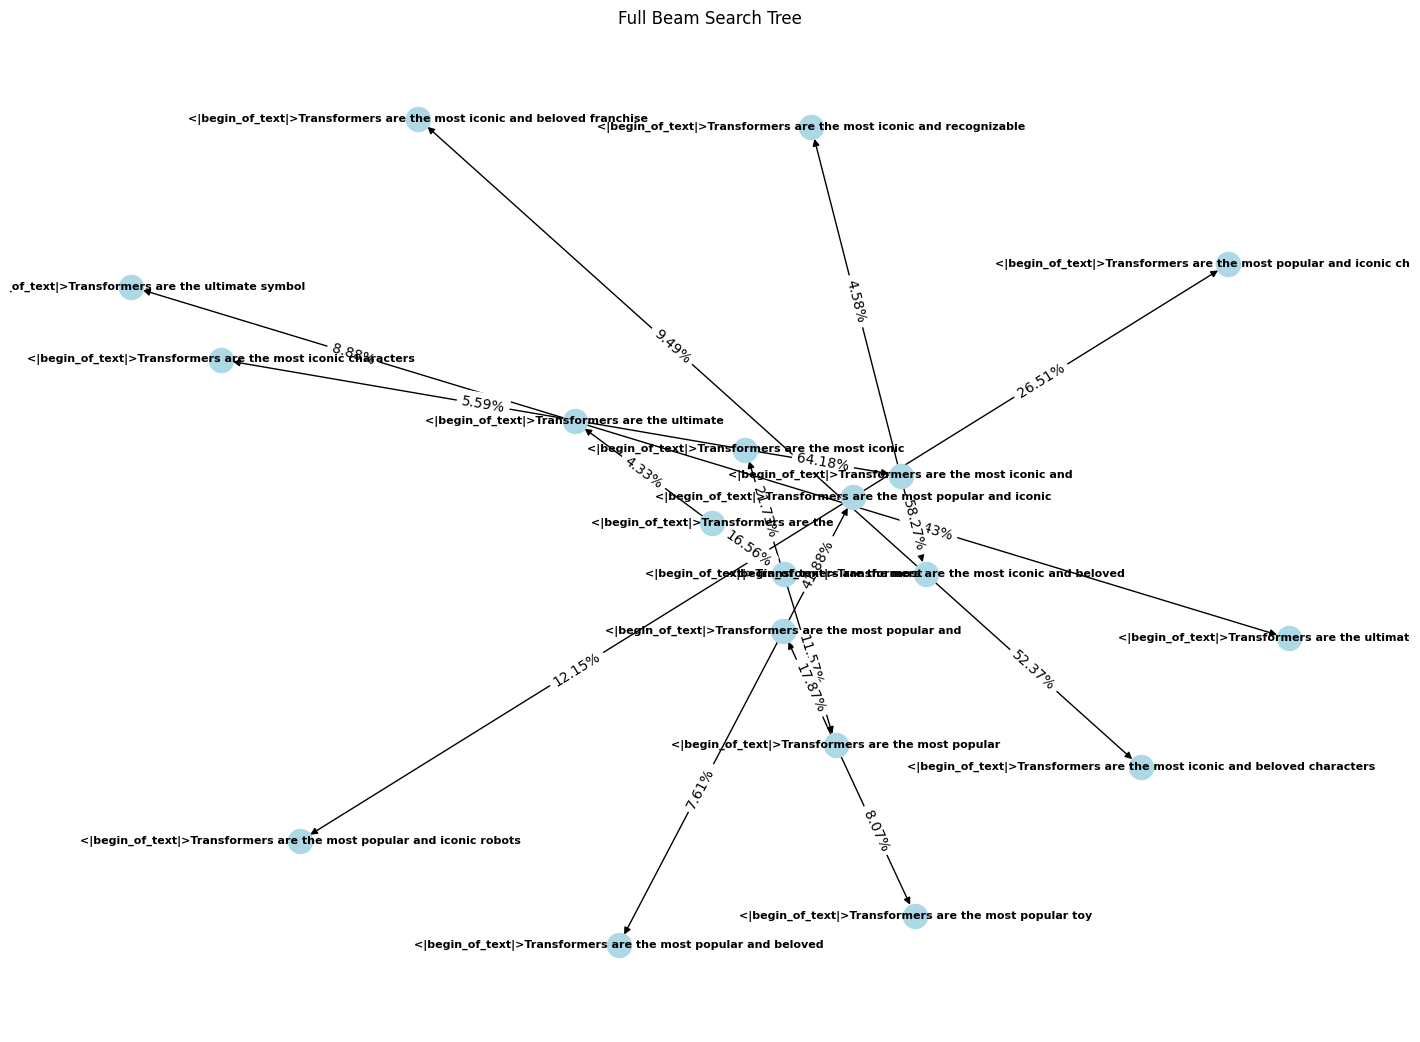

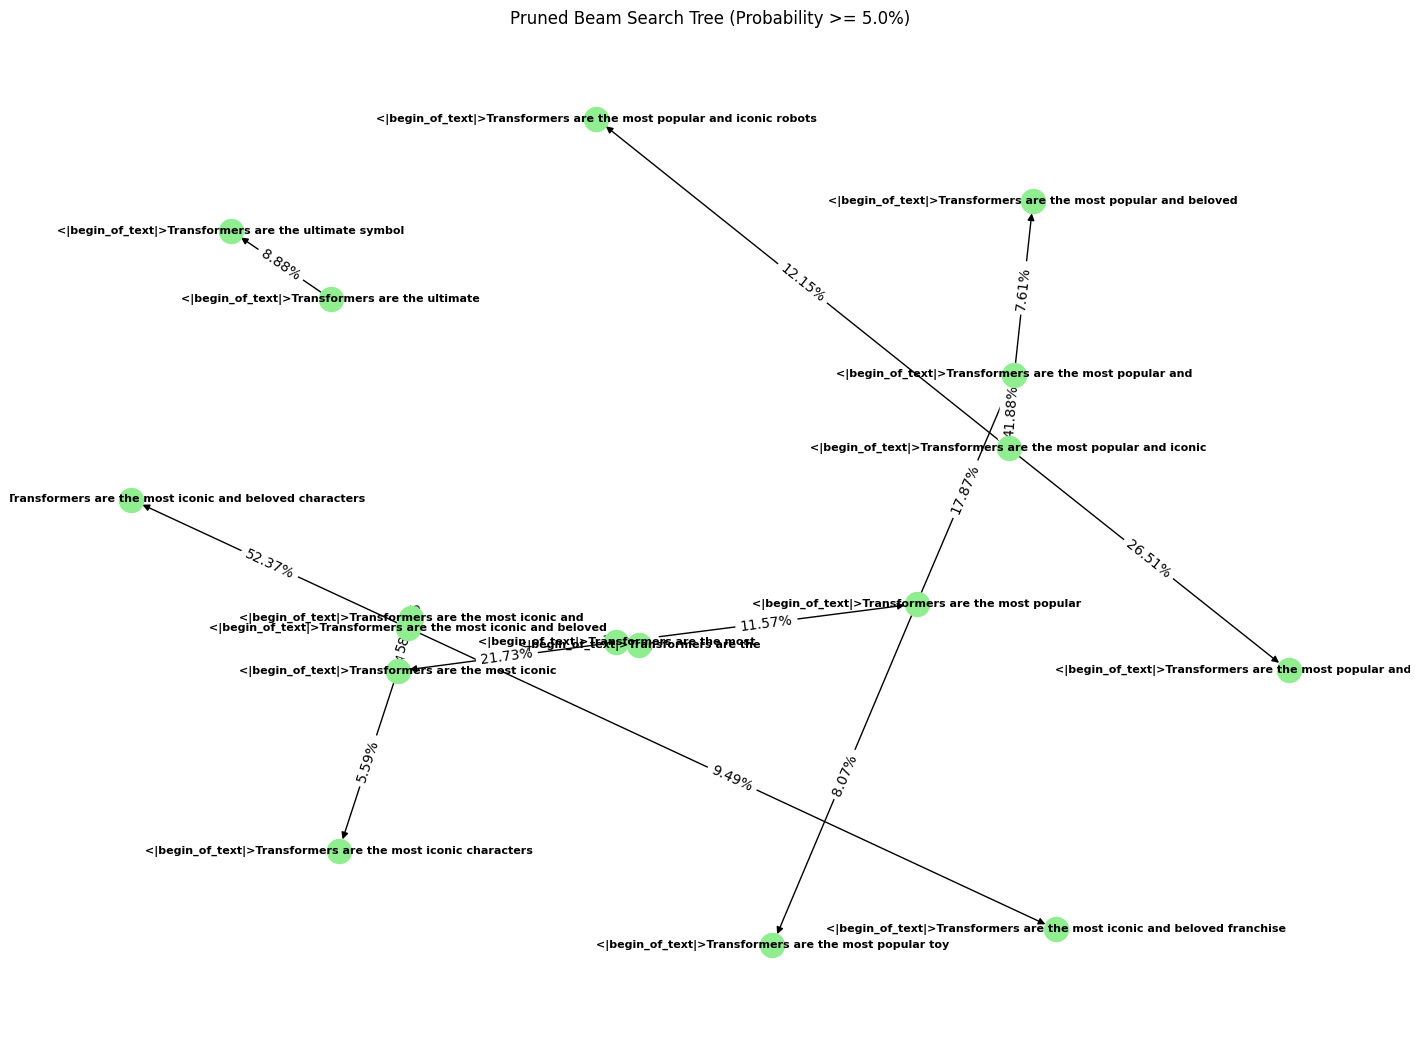

In [4]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the model and tokenizer (replace with your model name)
# model_name = "gpt2"  # example, change to your model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)

# Beam search parameters
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(model.device)
n_steps = 5
beam_size = 2
prob_threshold = 5.0  # Probability threshold for pruning in percent

# Initialize the beam
beams = [(input_ids, 1.0)]  # each beam is a tuple (input_ids, probability)
full_tree_structure = {}  # Dictionary to store full tree structure

node_counter = 1
# Step 1: Generate the full tree
with torch.no_grad():
    for step in range(n_steps):
        new_beams = []
        for input_ids, prob in beams:
            # Generate logits for the current input
            output = model(input_ids=input_ids)
            next_token_logits = output.logits[0, -1, :]
            next_token_probs = torch.softmax(next_token_logits, dim=-1)

            # Get the top beam_size next tokens
            sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)[
                :beam_size
            ]
            for idx, token_id in enumerate(sorted_ids):
                token_prob = next_token_probs[token_id].item()
                new_prob = prob * token_prob  # Update probability
                new_input_ids = torch.cat([input_ids, token_id.view(1, 1)], dim=-1)

                # Increment node counter for each new node
                node_counter += 1
                child_node = node_counter

                # Update full tree structure
                parent_text = tokenizer.decode(input_ids[0])
                child_text = tokenizer.decode(new_input_ids[0])
                full_tree_structure[(parent_text, child_text)] = (
                    100 * token_prob
                )  # Save as percentage

                # Store new beam
                new_beams.append((new_input_ids, new_prob))

        # Keep only the top beams after each step
        new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
        beams = new_beams  # Update beams

# Step 2: Prune the tree by creating a new tree with only edges above the probability threshold
pruned_tree_structure = {
    edge: prob for edge, prob in full_tree_structure.items() if prob >= prob_threshold
}

# Step 3: Visualize the Full Tree
G_full = nx.DiGraph()
for (parent, child), prob in full_tree_structure.items():
    G_full.add_edge(parent, child, weight=prob)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_full, seed=42)
edge_labels = nx.get_edge_attributes(G_full, "weight")
nx.draw(
    G_full,
    pos,
    with_labels=True,
    node_color="lightblue",
    font_size=8,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(
    G_full,
    pos,
    edge_labels={(u, v): f"{d:.2f}%" for u, v, d in G_full.edges(data="weight")},
)
plt.title("Full Beam Search Tree")
plt.show()

# Step 4: Visualize the Pruned Tree
G_pruned = nx.DiGraph()
for (parent, child), prob in pruned_tree_structure.items():
    G_pruned.add_edge(parent, child, weight=prob)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_pruned, seed=42)
edge_labels = nx.get_edge_attributes(G_pruned, "weight")
nx.draw(
    G_pruned,
    pos,
    with_labels=True,
    node_color="lightgreen",
    font_size=8,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(
    G_pruned,
    pos,
    edge_labels={(u, v): f"{d:.2f}%" for u, v, d in G_pruned.edges(data="weight")},
)
plt.title(f"Pruned Beam Search Tree (Probability >= {prob_threshold}%)")
plt.show()

token unknown: None
token unknown: None
token unknown: None
token unknown: None
[128000, 128009]
0:"

 token_prob=0.22176192700862885
1:

 token_prob=0.17270277440547943
2:"
 token_prob=0.1029166579246521
0:The token_prob=0.27332842350006104
1:I token_prob=0.14135965704917908
2:## token_prob=0.08830132335424423
0:The token_prob=0.197509765625
1:Answer token_prob=0.09591978043317795
2:## token_prob=0.08649802953004837
0:I token_prob=0.14928008615970612
1:The token_prob=0.14280015230178833
2:Answer token_prob=0.10065706074237823
0: chem token_prob=0.5917525887489319
1: answer token_prob=0.13971322774887085
2: name token_prob=0.04200227931141853
0: chem token_prob=0.5857838988304138
1: answer token_prob=0.14422574639320374
2: correct token_prob=0.05661507695913315
0:'m token_prob=0.18391883373260498
1: am token_prob=0.13828350603580475
2: think token_prob=0.11182956397533417
0:ist token_prob=0.9980142116546631
1:ists token_prob=0.001963237766176462
2:ism token_prob=7.2917559919005726e-06


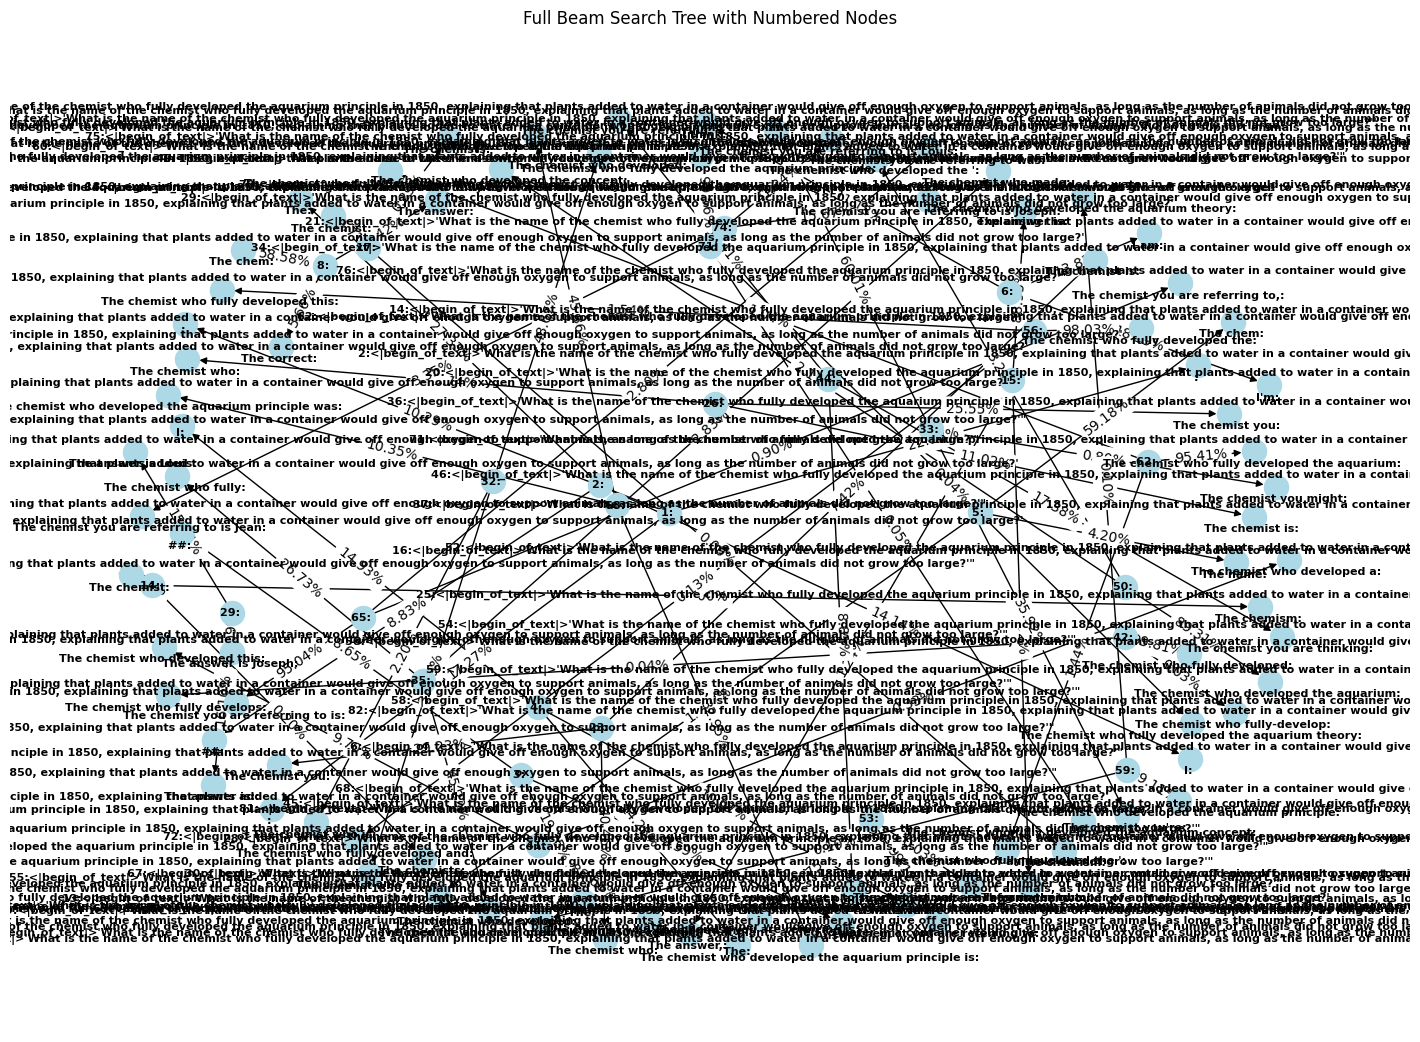

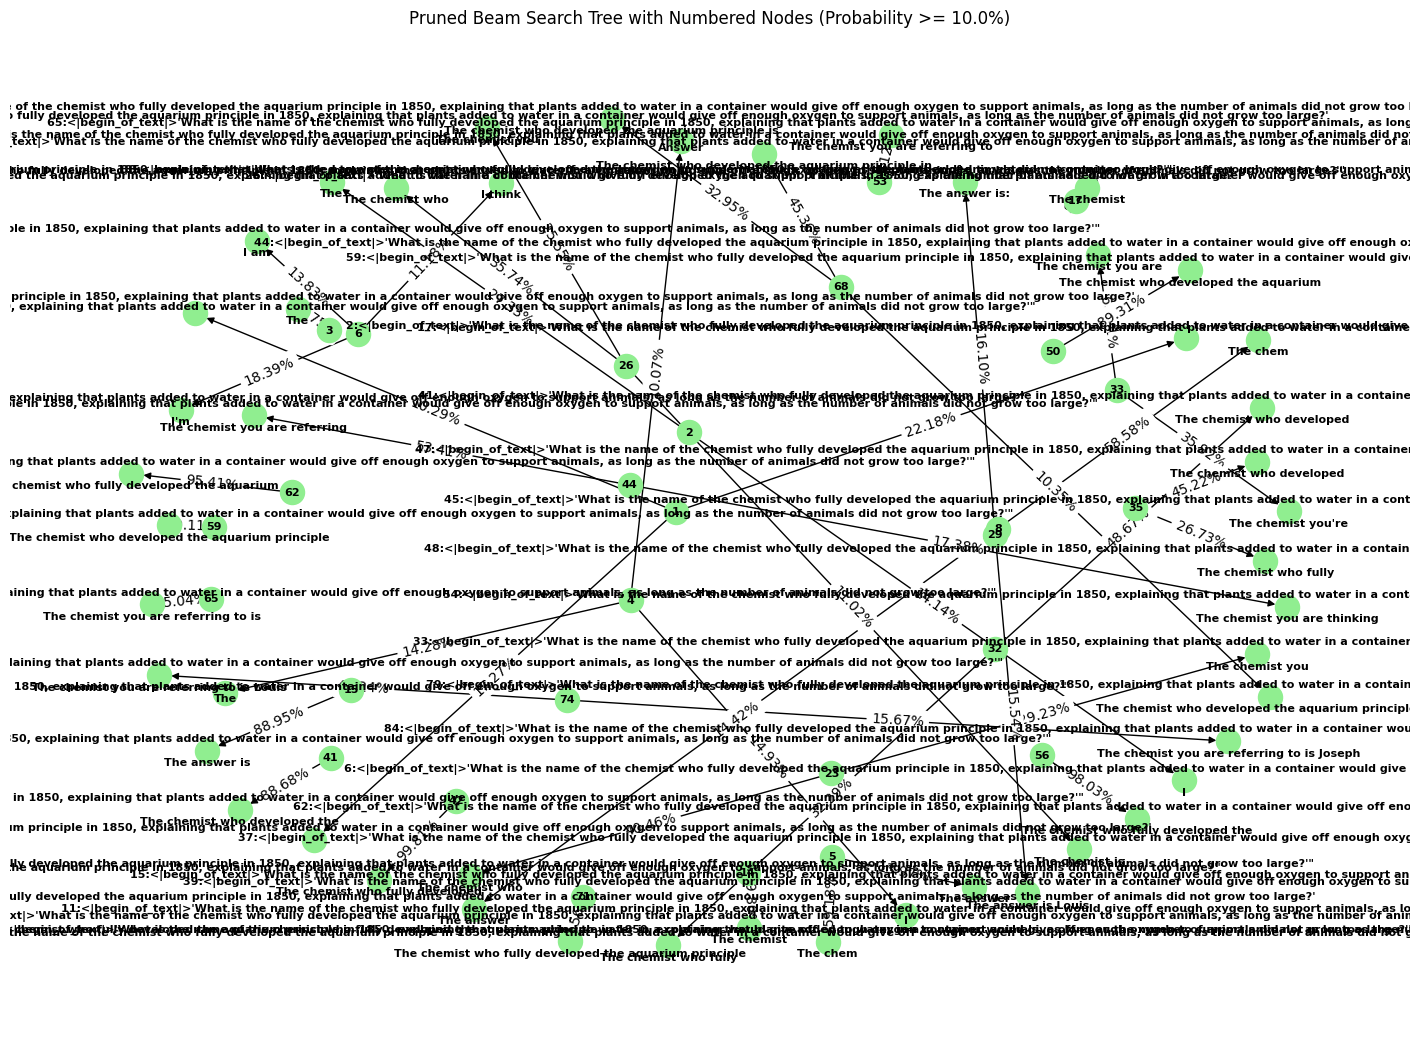

In [5]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the model and tokenizer (replace with your model name)
# model_name = "gpt2"  # example, change to your model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)

# Beam search parameters
input_txt = "Transformers are the"
input_txt = "Which Dutch player scored an open-play goal in the 2022 Netherlands vs Argentina game in the men’s FIFA World Cup?"
input_txt = "Answer in just the number the following question. How many more votes did Freeman Freeman-Thomas win than George Sandys in the 1906 Bodmin by-election?"
# input_txt = "Bil Keane won Best Syndicated Panel by the National Cartoonists Society's Award four times. Answer in True or False only and no other words?"
# input_txt = "What is 5 times 5 :"
input_txt = "What year did the Berlin wall fall ? Answer in the year only and no other characters or words."
input_txt = "'What is the name of the chemist who fully developed the aquarium principle in 1850, explaining that plants added to water in a container would give off enough oxygen to support animals, as long as the number of animals did not grow too large?'"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(model.device)
n_steps = 10
beam_size = 3
prob_threshold = 10.0  # Probability threshold for pruning in percent

# Initialize the beam and node counter
beams = [
    (input_ids, 1.0, 1)
]  # Each beam is a tuple (input_ids, probability, node_number)
node_counter = 1  # Start numbering nodes from 1
full_tree_structure = {}  # Dictionary to store full tree structure

special_token_ids = []
for attr in [
            "bos_token_id",
            "eos_token_id",
            "pad_token_id",
            "unk_token_id",
            "sep_token_id",
            "mask_token_id",
            ]:
            token_id = getattr(tokenizer, attr, None)
            if token_id is not None:
                special_token_ids.append(token_id)
            else:
                 print(f"token unknown: {token_id}")    

print(special_token_ids)

# Step 1: Generate the full tree with numbered nodes
with torch.no_grad():
    for step in range(n_steps):
        new_beams = []
        for input_ids, prob, parent_node in beams:
            # Generate logits for the current input
            output = model(input_ids=input_ids)
            next_token_logits = output.logits[0, -1, :]
            next_token_probs = torch.softmax(next_token_logits, dim=-1)

            # Get the top beam_size next tokens
            sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)[
                :beam_size
            ]
            for idx, token_id in enumerate(sorted_ids):
                token_prob = next_token_probs[token_id].item()
                new_prob = prob * token_prob  # Update probability
                new_input_ids = torch.cat([input_ids, token_id.view(1, 1)], dim=-1)

                # Decode the last token as a single word
                last_token = tokenizer.decode(token_id)
                print(f"{idx}:{last_token} token_prob={token_prob}")
                # Check if it's a single word without spaces
                #if " " in last_token:
                #    continue  # Skip tokens with spaces, ensuring only single words are used

                # Increment node counter for each new node
                node_counter += 1
                child_node = node_counter

                # Update full tree structure
                parent_text = tokenizer.decode(input_ids[0])
                child_text = f"{child_node}:{tokenizer.decode(new_input_ids[0])}"

                # Get only the last token for each node label
                #parent_text = tokenizer.decode(input_ids[0, -1:])
                #child_text = tokenizer.decode(new_input_ids[0, -1:])

                # Update full tree structure with numbered nodes
                full_tree_structure[(parent_node, child_text)] = (
                    100 * token_prob,
                    tokenizer.decode(new_input_ids[0]),
                )

                # Store new beam with the new child node number
                new_beams.append((new_input_ids, new_prob, child_node))

        # Keep only the top beams after each step
        new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
        beams = new_beams  # Update beams

# Step 2: Prune the tree by creating a new tree with only edges above the probability threshold
pruned_tree_structure = {
    edge: (prob, text)
    for edge, (prob, text) in full_tree_structure.items()
    if prob >= prob_threshold
}

# Step 3: Visualize the Full Tree with numbered nodes
G_full = nx.DiGraph()
for (parent, child), (prob, text) in full_tree_structure.items():
    G_full.add_edge(parent, child, weight=prob, label=text)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_full, seed=42)
edge_labels = nx.get_edge_attributes(G_full, "weight")
node_labels = {
    node: f"{node}: {G_full.nodes[node].get('label', '')}" for node in G_full.nodes
}
nx.draw(
    G_full,
    pos,
    with_labels=True,
    labels=node_labels,
    node_color="lightblue",
    font_size=8,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(
    G_full,
    pos,
    edge_labels={(u, v): f"{d:.2f}%" for u, v, d in G_full.edges(data="weight")},
)
plt.title("Full Beam Search Tree with Numbered Nodes")
plt.show()

# Step 4: Visualize the Pruned Tree with numbered nodes
G_pruned = nx.DiGraph()
for (parent, child), (prob, text) in pruned_tree_structure.items():
    G_pruned.add_edge(parent, child, weight=prob, label=text)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_pruned, seed=42)
edge_labels = nx.get_edge_attributes(G_pruned, "weight")
node_labels = {node: f"{node}" for node in G_pruned.nodes}  # Display node number only
nx.draw(
    G_pruned,
    pos,
    with_labels=True,
    labels=node_labels,
    node_color="lightgreen",
    font_size=8,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(
    G_pruned,
    pos,
    edge_labels={(u, v): f"{d:.2f}%" for u, v, d in G_pruned.edges(data="weight")},
)
plt.title(
    f"Pruned Beam Search Tree with Numbered Nodes (Probability >= {prob_threshold}%)"
)
plt.show()

Step 1, Generated token: '
', Probability: 32.52%
Step 1, Generated token: ' The', Probability: 4.06%
Step 1, Generated token: '

', Probability: 3.31%
Step 1, Generated token: ' (', Probability: 3.29%
Step 1, Generated token: ' [', Probability: 2.68%
Step 2, Generated token: '
', Probability: 99.73%
Step 2, Generated token: ''', Probability: 0.04%
Step 2, Generated token: 'The', Probability: 0.04%
Step 2, Generated token: 'A', Probability: 0.01%
Step 2, Generated token: 'In', Probability: 0.01%
Step 2, Generated token: ' answer', Probability: 5.50%
Step 2, Generated token: ' chemist', Probability: 3.97%
Step 2, Generated token: ' idea', Probability: 2.65%
Step 2, Generated token: ' question', Probability: 1.99%
Step 2, Generated token: ' following', Probability: 1.55%
Step 2, Generated token: '
', Probability: 99.95%
Step 2, Generated token: '.', Probability: 0.01%
Step 2, Generated token: ' (', Probability: 0.01%
Step 2, Generated token: ' '', Probability: 0.00%
Step 2, Generated tok

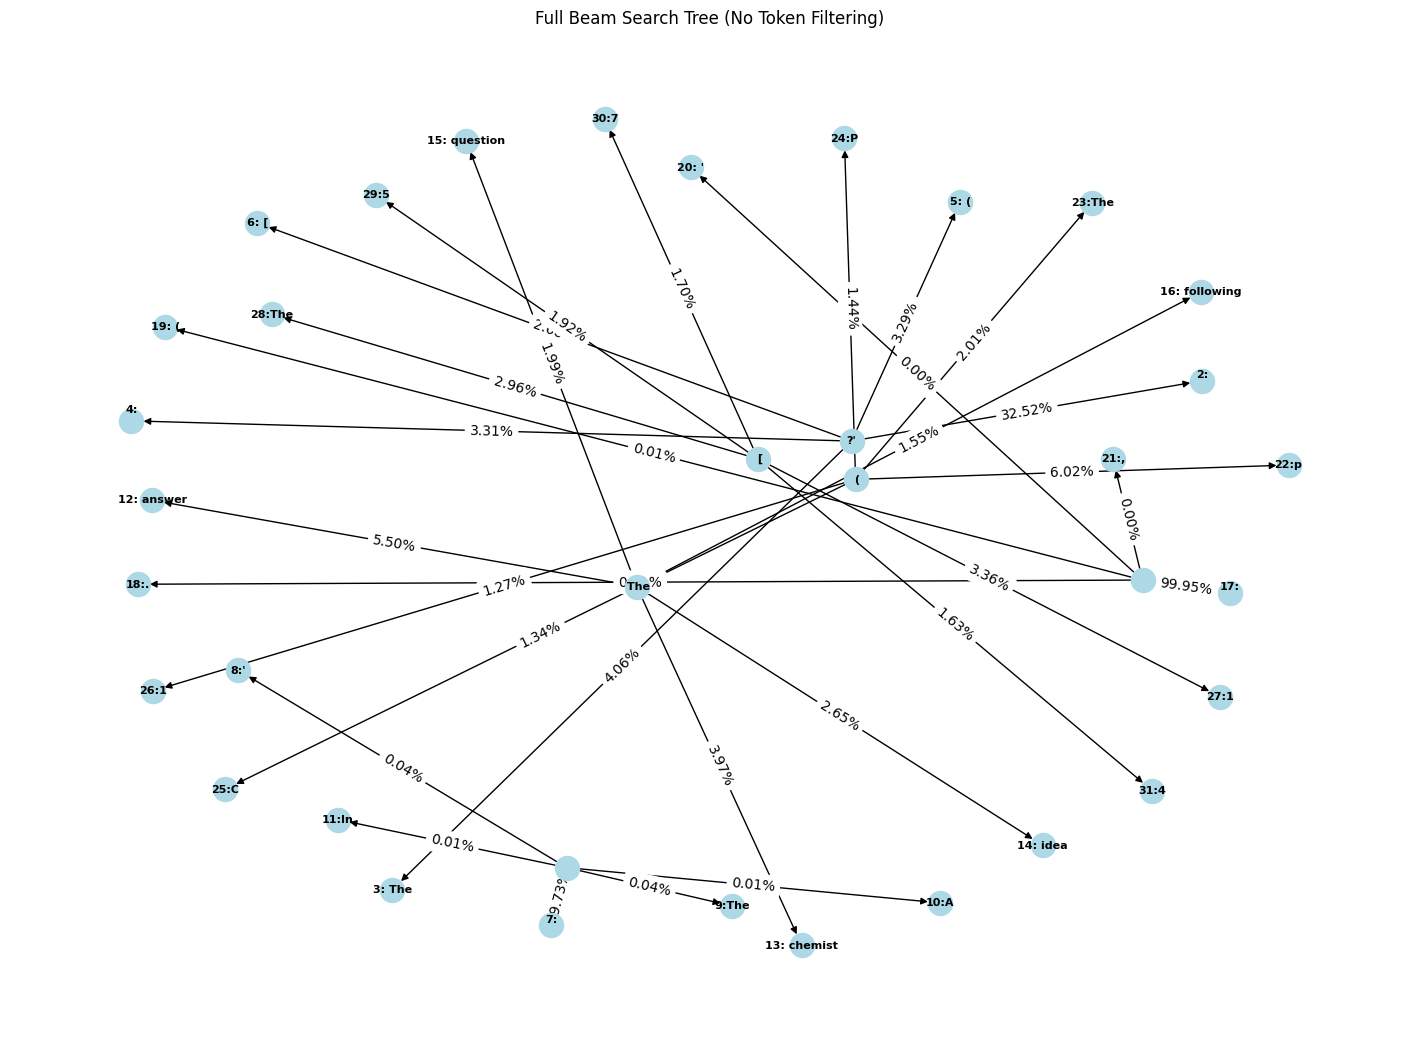

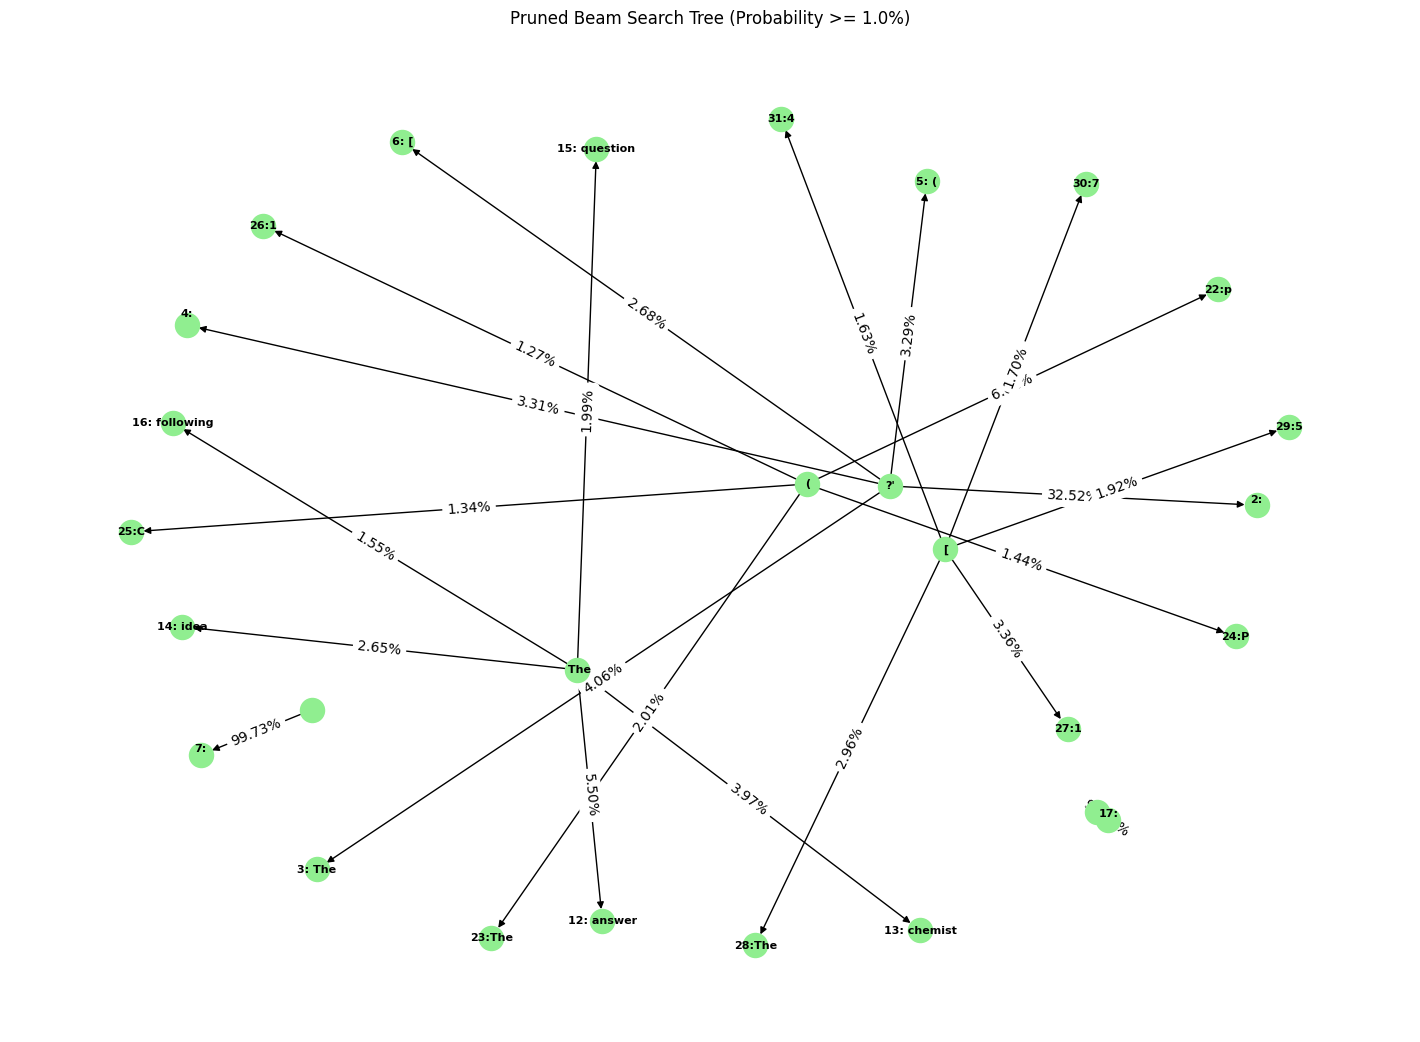

In [ ]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the model and tokenizer (replace with your model name)
# model_name = "gpt2"  # example, change to your model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)

# Beam search parameters
# input_txt = "Transformers are the"
# input_txt = "When  was Carrie Underwood\'s album \"Cry Pretty\" certified Gold by the RIAA?'"
input_txt = "Who won the Godman-Salvin Medal in 2010?"
input_txt = "'Give just the name of the chemist who fully developed the aquarium principle in 1850, explaining that plants added to water in a container would give off enough oxygen to support animals, as long as the number of animals did not grow too large?'"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(model.device)
n_steps = 2
beam_size = 5
prob_threshold = 1.0  # Lowered probability threshold for testing

# Initialize the beam
beams = [(input_ids, 1.0)]  # each beam is a tuple (input_ids, probability)
full_tree_structure = {}  # Dictionary to store full tree structure

node_counter = 1

# Step 1: Generate the full tree with debug prints
with torch.no_grad():
    for step in range(n_steps):
        new_beams = []
        for input_ids, prob in beams:
            # Generate logits for the current input
            output = model(input_ids=input_ids)
            next_token_logits = output.logits[0, -1, :]
            next_token_probs = torch.softmax(next_token_logits, dim=-1)

            # Get the top beam_size next tokens
            sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)[
                :beam_size
            ]
            for idx, token_id in enumerate(sorted_ids):
                token_prob = next_token_probs[token_id].item()
                new_prob = prob * token_prob  # Update probability
                new_input_ids = torch.cat([input_ids, token_id.view(1, 1)], dim=-1)

                # Decode the last token
                last_token = tokenizer.decode(token_id)

                # Debug: Print token and probability for every generated token
                print(
                    f"Step {step + 1}, Generated token: '{last_token}', Probability: {100 * token_prob:.2f}%"
                )

                # Increment node counter for each new node
                node_counter += 1
                child_node = node_counter
                # Update full tree structure with all tokens, no filtering
                parent_text = tokenizer.decode(input_ids[0, -1:])
                #child_text = last_token  # Use only the last token as the node label
                #child_text = f"{child_node}:{tokenizer.decode(new_input_ids[0])}"
                child_text = f"{child_node}:{last_token}"

                full_tree_structure[(parent_text, child_text)] = (
                    100 * token_prob
                )  # Save as percentage

                # Store new beam
                new_beams.append((new_input_ids, new_prob))

        # Keep only the top beams after each step
        new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
        beams = new_beams  # Update beams

# Step 2: Prune the tree by creating a new tree with only edges above the probability threshold
pruned_tree_structure = {
    edge: prob for edge, prob in full_tree_structure.items() if prob >= prob_threshold
}

# Debug: Print the pruned tree structure
print("\nPruned Tree Structure:")
for edge, prob in pruned_tree_structure.items():
    print(f"Edge: {edge}, Probability: {prob:.2f}%")

# Step 3: Visualize the Full Tree
G_full = nx.DiGraph()
for (parent, child), prob in full_tree_structure.items():
    G_full.add_edge(parent, child, weight=prob)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_full, seed=42)
edge_labels = nx.get_edge_attributes(G_full, "weight")
nx.draw(
    G_full,
    pos,
    with_labels=True,
    node_color="lightblue",
    font_size=8,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(
    G_full,
    pos,
    edge_labels={(u, v): f"{d:.2f}%" for u, v, d in G_full.edges(data="weight")},
)
plt.title("Full Beam Search Tree (No Token Filtering)")
plt.show()

# Step 4: Visualize the Pruned Tree
G_pruned = nx.DiGraph()
for (parent, child), prob in pruned_tree_structure.items():
    G_pruned.add_edge(parent, child, weight=prob)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_pruned, seed=42)
edge_labels = nx.get_edge_attributes(G_pruned, "weight")
nx.draw(
    G_pruned,
    pos,
    with_labels=True,
    node_color="lightgreen",
    font_size=8,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(
    G_pruned,
    pos,
    edge_labels={(u, v): f"{d:.2f}%" for u, v, d in G_pruned.edges(data="weight")},
)
plt.title(f"Pruned Beam Search Tree (Probability >= {prob_threshold}%)")
plt.show()

In [ ]:
# hide_output
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# input_txt = "'What is the name of the chemist who fully developed the aquarium principle in 1850, explaining that plants added to water in a container would give off enough oxygen to support animals, as long as the number of animals did not grow too large?'"
input_txt = "Who won the Heinz Hopf Prize in 2019?"
input_txt = "Who did the International Photography Awards of 2020 give the Nature Photographer of the Year Award to?"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 40
choices_per_step = 8

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = input_txt
        #iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            iteration[f"Seq {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

Input  \
0   Who did the International Photography Awards o...   
1   Who did the International Photography Awards o...   
2   Who did the International Photography Awards o...   
3   Who did the International Photography Awards o...   
4   Who did the International Photography Awards o...   
5   Who did the International Photography Awards o...   
6   Who did the International Photography Awards o...   
7   Who did the International Photography Awards o...   
8   Who did the International Photography Awards o...   
9   Who did the International Photography Awards o...   
10  Who did the International Photography Awards o...   
11  Who did the International Photography Awards o...   
12  Who did the International Photography Awards o...   
13  Who did the International Photography Awards o...   
14  Who did the International Photography Awards o...   
15  Who did the International Photography Awards o...   
16  Who did the International Photography Awards o...   
17  Who did the International Photography Awards o...   
18  Who did the International Photography Awards o...   
19  Who did the International Photography Awards o...   
20  Who did the International Photography Awards o...   
21  Who did the International Photography Awards o...   
22  Who did the International Photography Awards o...   
23  Who did the International Photography Awards o...   
24  Who did the International Photography Awards o...   
25  Who did the International Photography Awards o...   
26  Who did the International Photography Awards o...   
27  Who did the International Photography Awards o...   
28  Who did the International Photography Awards o...   
29  Who did the International Photography Awards o...   
30  Who did the International Photography Awards o...   
31  Who did the International Photography Awards o...   
32  Who did the International Photography Awards o...   
33  Who did the International Photography Awards o...   
34  Who did the International Photography Awards o...   
35  Who did the International Photography Awards o...   
36  Who did the International Photography Awards o...   
37  Who did the International Photography Awards o...   
38  Who did the International Photography Awards o...   
39  Who did the International Photography Awards o...   

                           Seq 1                  Seq 2  \
0                     \n (7.01%)            The (2.89%)   
1                   The (18.61%)              I (9.28%)   
2         International (32.85%)         award (12.32%)   
3           Photography (99.04%)   Photographer (0.18%)   
4                Awards (99.24%)          Award (0.40%)   
5                    of (62.70%)               (11.57%)   
6                       (99.69%)            the (0.13%)   
7                   202 (99.42%)            201 (0.46%)   
8                     0 (99.56%)              1 (0.26%)   
9                  gave (56.74%)              , (7.66%)   
10                  the (94.85%)         Nature (0.76%)   
11               Nature (92.91%)          award (1.40%)   
12         Photographer (99.11%)    Photography (0.44%)   
13                   of (99.93%)          Award (0.02%)   
14                  the (99.94%)            The (0.02%)   
15                 Year (99.18%)           year (0.71%)   
16                Award (96.50%)          award (3.07%)   
17                   to (98.45%)                (0.17%)   
18                       (7.06%)             \n (1.35%)   
19                    ** (0.94%)            Ben (0.92%)   
20                 David (2.31%)              S (1.54%)   
21                   Not (3.73%)         Slater (2.79%)   
22                  ari (16.98%)            te (13.38%)   
23                   ** (29.13%)             . (15.36%)   
24                    . (30.45%)            \n (10.20%)   
25           <|eot_id|> (30.51%)          \n\n (19.16%)   
26  <|start_header_id|> (99.50%)     <|eot_id|> (0.06%)   
27            assistant (84.05%)           \n\n (1.46%)   

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Input text
input_text = "The universe is"
input_ids = tokenizer.encode(
    input_text, return_tensors="pt"
)  # Convert text to token IDs

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_ids = input_ids.to(device)

# Parameters
k = 5  # Number of top tokens to consider
max_length = 40  # Maximum length of the generated sequence

# Generate text
with torch.no_grad():
    for _ in range(max_length - len(input_ids[0])):
        # Pass input through the model
        outputs = model(input_ids)
        logits = outputs.logits

        # Get the logits of the last token
        last_token_logits = logits[:, -1, :]  # Shape: [batch_size, vocab_size]

        # Apply top-k filtering
        top_k_logits, top_k_indices = torch.topk(last_token_logits, k=k)

        # Sample from the top-k tokens
        probabilities = torch.softmax(top_k_logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1)  # Sample one token
        next_token_id = top_k_indices.gather(dim=-1, index=next_token)

        # Append the new token to the input sequence
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)

# Decode the generated sequence
generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
print("Generated Text:", generated_text)

Generated Text: The universe is a complex system. It is not an infinite system. The universe is a finite system that is a single-dimensional universe. There are two ways to understand the universe. The first way


In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model.eval()

# Input text
input_text = "The universe is"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
attention_mask = torch.ones_like(input_ids)  # Start with all valid tokens

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Parameters
k = 5  # Top-k tokens to consider
max_length = 20

# Generate text
with torch.no_grad():
    for _ in range(max_length - len(input_ids[0])):
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get logits for the last token
        last_token_logits = logits[:, -1, :]  # Shape: [batch_size, vocab_size]

        # Top-k filtering
        top_k_logits, top_k_indices = torch.topk(last_token_logits, k=k)

        # Sample from the top-k tokens
        probabilities = torch.softmax(top_k_logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1)  # Sample one token
        next_token_id = top_k_indices.gather(dim=-1, index=next_token)

        # Append the new token to the sequence
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)

        # Update the attention mask
        new_attention = torch.ones((1, 1), dtype=torch.long, device=device)
        attention_mask = torch.cat([attention_mask, new_attention], dim=-1)

# Decode the generated sequence
generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
print("Generated Text:", generated_text)

Generated Text: The universe is a vast collection of universes, each with its own unique set of laws.




In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Initialize the model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Input text
input_text = "Artificial intelligence is"
input_ids = tokenizer.encode(input_text, return_tensors="pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_ids = input_ids.to(device)

# Parameters
k = 3  # Top-k tokens to consider
beam_width = 10 # Number of beams
max_length = 20

# Initialize beams
beams = [(input_ids, 0.0)]  # Each beam is a tuple (sequence, score)

with torch.no_grad():
    for _ in range(max_length - len(input_ids[0])):
        new_beams = []
        for seq, score in beams:
            outputs = model(seq)
            logits = outputs.logits[:, -1, :]  # Logits for the last token
            top_k_logits, top_k_indices = torch.topk(logits, k=k)

            # For each token in top-k, create a new beam
            for i in range(k):
                token_id = top_k_indices[0, i].unsqueeze(0).unsqueeze(0)  # Shape: [1, 1]
                token_score = top_k_logits[0, i].item()

                new_seq = torch.cat([seq, token_id], dim=-1)
                new_score = score + token_score  # Add log probabilities
                new_beams.append((new_seq, new_score))

        # Keep only the top `beam_width` beams
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

# Decode and print all beam results
for idx, (seq, score) in enumerate(beams):
    decoded_text = tokenizer.decode(seq[0], skip_special_tokens=True)
    print(f"Beam {idx + 1}: {decoded_text}")


Beam 1: Artificial intelligence is the next step in artificial-computers' ability and ability-to–learn
Beam 2: Artificial intelligence is the next step in artificial-computers' ability and ability-to–machine
Beam 3: Artificial intelligence is the next step in artificial-computers' ability and ability-to–human
Beam 4: Artificial intelligence is the next step in artificial-computers' ability and ability-to-learn
Beam 5: Artificial intelligence is the next step in artificial-computers' ability and ability-to-read
Beam 6: Artificial intelligence is the next step in artificial-computers' ability and ability-to-know
Beam 7: Artificial intelligence is the next step in artificial-computers' ability and ability-building process.
Beam 8: Artificial intelligence is the next step in artificial-computers' ability and ability-building capabilities.
Beam 9: Artificial intelligence is the next step in artificial-computers' ability and ability-building capabilities,
Beam 10: Artificial intelligence is 

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Input text
input_text = "Artificial intelligence is"
input_ids = tokenizer.encode(input_text, return_tensors="pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids = input_ids.to(device)
model.to(device)

# Parameters
beam_width = 5  # Number of beams
max_length = 20
diversity_strength = 0.7  # Higher values increase diversity

# Initialize beams
beams = [(input_ids, 0.0)]  # (sequence, score)

# Beam Search with Diversity
with torch.no_grad():
    for _ in range(max_length - input_ids.shape[-1]):
        new_beams = []
        for seq, score in beams:
            outputs = model(seq)
            logits = outputs.logits[:, -1, :]  # Logits for the last token

            # Apply top-k sampling
            top_k_logits, top_k_indices = torch.topk(logits, k=beam_width)
            probabilities = torch.softmax(top_k_logits, dim=-1)

            # Generate new beams
            for i in range(beam_width):
                token_id = top_k_indices[0, i].unsqueeze(0).unsqueeze(0)
                token_score = top_k_logits[0, i].item()

                # Penalize tokens already present in the sequence (diversity)
                diversity_penalty = diversity_strength * (seq == token_id).sum().item()

                new_seq = torch.cat([seq, token_id], dim=-1)
                new_score = score + token_score - diversity_penalty
                new_beams.append((new_seq, new_score))

        # Select top beams for the next iteration
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

# Decode and print beam results
for idx, (seq, score) in enumerate(beams):
    decoded_text = tokenizer.decode(seq[0], skip_special_tokens=True)
    print(f"Beam {idx + 1}: {decoded_text}")

Beam 1: Artificial intelligence is an area in need of attention as well."The United Kingdom's Foreign Office
Beam 2: Artificial intelligence is an area in need of attention as well."The United Kingdom's Foreign Secretary
Beam 3: Artificial intelligence is an area in need of attention as well."The United Kingdom's Foreign and
Beam 4: Artificial intelligence is an area in need of attention as well."The United Kingdom's Foreign Minister
Beam 5: Artificial intelligence is an area in need of attention as well."The United Kingdom's Foreign Affairs


In [24]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
model_name = "meta-llama/Llama-3.2-1B-Instruct"

# Load pre-trained model and tokenizer
# model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

# Input text
input_text = "Artificial intelligence is"
input_ids = tokenizer.encode(input_text, return_tensors="pt")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# input_ids = input_ids.to(device)
# model.to(device)

# Parameters
beam_width = 5  # Number of beams
max_length = 20  # Maximum length of generated sequence
top_p = 0.1  # Nucleus sampling threshold
diversity_strength = 0.1  # Diversity penalty factor

K = 1
# Initialize beams
beams = [(input_ids, 0.0)]  # Each beam is a tuple (sequence, score)

output_ids = input_ids

# Beam Search with Nucleus Sampling
with torch.no_grad():
    for _ in range(max_length - input_ids.shape[-1]):
        new_beams = []
        for seq, score in beams:
            # Pass current beam sequence through the model
            outputs = model(seq)
            logits = outputs.logits[:, -1, :]  # Logits for the last token

            # Apply nucleus sampling
            # Sort logits and calculate cumulative probabilities
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)



            # Debugging
            print("Cumulative probabilities (sample):", cumulative_probs[0].to("cpu"))
            print("Tokens removed (sample):", sorted_indices_to_remove[0].sum().item())
            print("Tokens kept (sample):", (~sorted_indices_to_remove[0]).sum().item())



            # Mask tokens outside the nucleus (top-p)
            # Create mask for top-p filtering
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = False  # Ensure at least one token is kept

            # Debugging shapes
            print("Logits shape:", logits.shape)
            print("Sorted indices shape:", sorted_indices.shape)
            print("Sorted indices to remove shape:", sorted_indices_to_remove.shape)
            print("Cumulative probabilities:", cumulative_probs[0].to("cpu"))  # Check the first batch

            print("Tokens removed:", sorted_indices_to_remove[0].sum().item())  # Number of masked tokens
            print("Tokens kept:", (~sorted_indices_to_remove[0]).sum().item())  # Number of unmasked tokens


            # Apply mask (correct dimensions)
            for batch_idx in range(logits.size(0)):  # Handle each batch independently
                logits[
                    batch_idx, sorted_indices[batch_idx, sorted_indices_to_remove[batch_idx]]
                ] = -float("Inf")
            print("Logits after top-p filtering:", logits)
            print("Max logits:", logits.max())
            print("Min logits:", logits.min())

            #logits[sorted_indices[sorted_indices_to_remove]] = -float("Inf")
            top_k_logits, top_k_indices = torch.topk(logits, k=K)

            # Sample from the filtered logits
            probabilities = torch.softmax(top_k_logits, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1)
            next_token_id = top_k_indices.gather(dim=-1, index=next_token)

            # Append the next token to the sequence
            output_ids = torch.cat([output_ids, next_token_id], dim=-1)

# Decode output
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Generated Text:", generated_text)

Cumulative probabilities (sample): tensor([0.2416, 0.3421, 0.3965,  ..., 1.0001, 1.0001, 1.0001])
Tokens removed (sample): 128255
Tokens kept (sample): 1
Logits shape: torch.Size([1, 128256])
Sorted indices shape: torch.Size([1, 128256])
Sorted indices to remove shape: torch.Size([1, 128256])
Cumulative probabilities: tensor([0.2416, 0.3421, 0.3965,  ..., 1.0001, 1.0001, 1.0001])
Tokens removed: 128255
Tokens kept: 1
Logits after top-p filtering: tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]])
Max logits: tensor(19.9337)
Min logits: tensor(-inf)
Cumulative probabilities (sample): tensor([0.2416, 0.3421, 0.3965,  ..., 1.0001, 1.0001, 1.0001])
Tokens removed (sample): 128255
Tokens kept (sample): 1
Logits shape: torch.Size([1, 128256])
Sorted indices shape: torch.Size([1, 128256])
Sorted indices to remove shape: torch.Size([1, 128256])
Cumulative probabilities: tensor([0.2416, 0.3421, 0.3965,  ..., 1.0001, 1.0001, 1.0001])
Tokens removed: 128255
Tokens kept: 1
Logits after top-p fil

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Load model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model.eval()

# Input
input_text = "Once upon a time"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# Parameters
k = 10  # Top-k sampling
p = 0.9  # Top-p (nucleus) sampling
max_length = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids = input_ids.to(device)
model.to(device)

# Generate
output_ids = input_ids
with torch.no_grad():
    for _ in range(max_length - input_ids.shape[-1]):
        outputs = model(output_ids)
        logits = outputs.logits[:, -1, :]  # Logits for the last token

        # Apply top-k and nucleus sampling
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)

        # Mask tokens beyond nucleus threshold
        sorted_indices_to_remove = cumulative_probs > p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
            ..., :-1
        ].clone()
        sorted_indices_to_remove[..., 0] = 0  # Ensure at least one token is kept

        logits[sorted_indices[sorted_indices_to_remove]] = -float("Inf")
        top_k_logits, top_k_indices = torch.topk(logits, k=k)

        # Sample from the filtered logits
        probabilities = torch.softmax(top_k_logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1)
        next_token_id = top_k_indices.gather(dim=-1, index=next_token)

        # Append the next token to the sequence
        output_ids = torch.cat([output_ids, next_token_id], dim=-1)

# Decode output
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Generated Text:", generated_text)


In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
#output = model.generate(**input_txt, max_new_tokens=n_steps, do_sample=False)
output = model.generate(input_ids )
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>How many r's in the word strawberry?

## Step 1: Write down the word strawberry


/home/anup/work/finetune/.venv/lib/python3.12/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


The chemist who developed the aquarium principle in 1850 is Louis Agassiz.


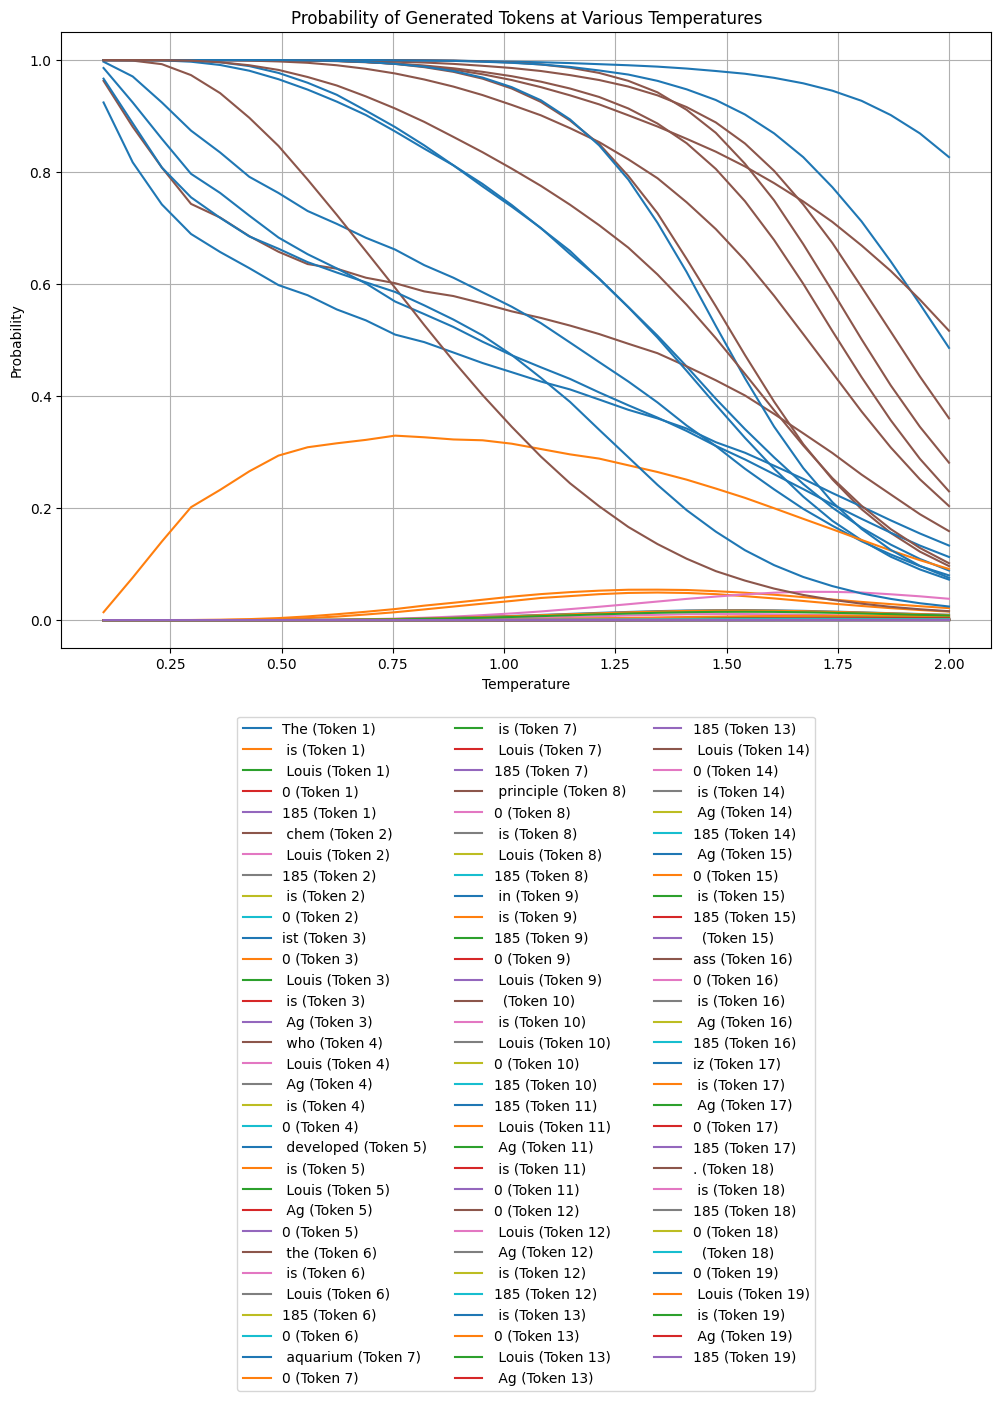

In [ ]:
# Assuming logits_history contains logits for each generated token
logits_history = []

# Example generation loop (store logits for each step)
for step in range(max_new_tokens):
    with torch.no_grad():
        outputs = model(
            input_ids if past_key_values is None else input_ids[:, -1:],
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            use_cache=True,
            output_attentions=True,
        )

    logits = outputs.logits[:, -1, :]  # Get logits for the last generated token
    logits_history.append(logits.squeeze().cpu())  # Save logits to CPU for plotting
    attention_scores = outputs.attentions[-1]
    past_key_values = outputs.past_key_values

    next_token = torch.argmax(logits, dim=-1, keepdim=True).to(torch.int32)

    if torch.isin(next_token, stop).any():
        break

    generated_tokens.append(next_token.item())
    gen_tokens = torch.cat((gen_tokens, next_token), dim=1)
    input_ids = torch.cat([input_ids, next_token], dim=-1)
    attention_mask = torch.cat(
        [attention_mask, torch.ones((1, 1), device=device, dtype=torch.long)],
        dim=-1,
    )


num_tokens = len(logits_history)

plt.figure(figsize=(12, 8))

for token_idx in range(num_tokens):
    token_logits = logits_history[token_idx]
    decoded_tokens = []  # To store top-N tokens for the current step
    token_probabilities = []  # To store probabilities for each top-N token

    for temp in temperatures:
        scaled_logits = token_logits / temp
        probs = torch.softmax(scaled_logits, dim=-1)

        # Get top-N generated tokens and probabilities only
        generated_token_probs = probs[generated_tokens]
        top_n_values, top_n_indices = torch.topk(generated_token_probs, top_n)

        top_n_probs = top_n_values
        top_n_tokens = [
            tokenizer.decode([generated_tokens[idx]]) for idx in top_n_indices
        ]

        # Store probabilities for each temperature
        token_probabilities.append(top_n_probs)

        # Store token labels for the first temperature to avoid duplicates
        if temp == temperatures[0]:
            decoded_tokens = top_n_tokens

    token_probabilities = torch.stack(token_probabilities).transpose(
        0, 1
    )  # Shape: (top_n, len(temperatures))

    # Plot each of the top-N tokens and label with the decoded token text
    for i in range(top_n):
        plt.plot(
            temperatures.numpy(),
            token_probabilities[i].numpy(),
            label=f"{decoded_tokens[i]} (Token {token_idx + 1})",
        )

generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
print(generated_text)

plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.title("Probability of Generated Tokens at Various Temperatures")

# Move the legend to the bottom
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.grid()
plt.show()
